In [1]:
#main directories
train_dir = '/kaggle/input/fer2013/train'
test_dir  = '/kaggle/input/fer2013/test'

In [2]:
import os
#analyzing our data
lable_names = os.listdir(train_dir)
print(f'class labels:{lable_names}')

for i in lable_names:
  print(f'\nnumber of train images in class {i} is: {len(os.listdir(os.path.join(train_dir, i)))}')
  print(f'number of test  images in class {i} is: {len(os.listdir(os.path.join(test_dir, i)))}')

class labels:['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

number of train images in class surprise is: 3171
number of test  images in class surprise is: 831

number of train images in class fear is: 4097
number of test  images in class fear is: 1024

number of train images in class angry is: 3995
number of test  images in class angry is: 958

number of train images in class neutral is: 4965
number of test  images in class neutral is: 1233

number of train images in class sad is: 4830
number of test  images in class sad is: 1247

number of train images in class disgust is: 436
number of test  images in class disgust is: 111

number of train images in class happy is: 7215
number of test  images in class happy is: 1774


<Axes: >

<Figure size 1500x1000 with 0 Axes>

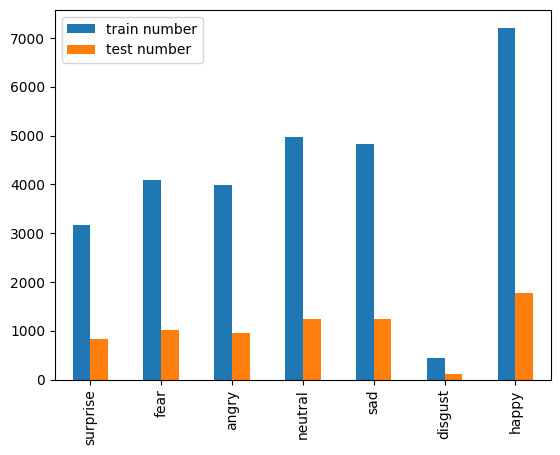

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
dict = {}
for i in lable_names:
  dict.update(({i:[ len(os.listdir(os.path.join(train_dir, i))) , len(os.listdir(os.path.join(test_dir, i)))]}))

df = pd.DataFrame(dict).T
df.columns = ['train number', 'test number']

plt.figure(figsize = (15,10))
df.plot(kind = 'bar' )

not so much balanced!

In [4]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    #first conv layer
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(48, 48, 3)),#, input_shape=(48, 48, 3)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
#     tf.keras.layers.Dropout(0.1),

    #second conv layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tf.keras.layers.Dropout(0.1),
    
    #third conv layer
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
#     tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(7, activation='softmax')
])


model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy', metrics=["accuracy"])

2024-02-18 07:02:48.714337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 07:02:48.714455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 07:02:48.821289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 32)        128       
 chNormalization)                                                
                                                        

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen  = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(48, 48),  # All images will be resized to 48x48
        batch_size=64,
        class_mode='categorical',# Since we use categorical_crossentropy loss, we need categorical labels
        shuffle = False)


# Flow validation images in batches of 64 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical',
        shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
#setting different weights for different classes because of imbalanced data
from sklearn.utils.class_weight import compute_class_weight


# "If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))."
class_weights = compute_class_weight("balanced", classes=train_generator.classes, y=train_generator.classes)
class_weight = {class_id: weight for class_id, weight in zip(train_generator.classes, class_weights)}

In [8]:
# Constant for epochs
EPOCHS = 100
EarlyStopping = tf.keras.callbacks.EarlyStopping

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch = 28709 // 64,  # 28709 images = batch_size(64) * steps
      epochs=EPOCHS,
      validation_data = validation_generator,
      validation_steps = 7178 // 64,  # 7178 images = batch_size(64) * steps
      verbose=1,
      class_weight=class_weight ,   #uneven class weights to cope with imbalanced data
      callbacks=EarlyStopping(monitor="val_loss", verbose = 1, patience = 6, mode = 'min', restore_best_weights=True)
      )

Epoch 1/100


2024-02-18 07:03:20.773858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708239803.718289      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 [==============================] - 274s 599ms/step - loss: 2.2351 - accuracy: 0.1690 - val_loss: 1.8971 - val_accuracy: 0.2222
Epoch 2/100
448/448 [==============================] - 49s 109ms/step - loss: 1.9905 - accuracy: 0.1852 - val_loss: 1.8695 - val_accuracy: 0.2062
Epoch 3/100
448/448 [==============================] - 49s 109ms/step - loss: 1.8220 - accuracy: 0.2482 - val_loss: 1.6567 - val_accuracy: 0.3504
Epoch 4/100
448/448 [==============================] - 49s 108ms/step - loss: 1.7048 - accuracy: 0.3112 - val_loss: 1.6694 - val_accuracy: 0.3570
Epoch 5/100
448/448 [==============================] - 48s 107ms/step - loss: 1.4860 - accuracy: 0.3894 - val_loss: 1.6166 - val_accuracy: 0.3788
Epoch 6/100
448/448 [==============================] - 49s 109ms/step - loss: 1.3634 - accuracy: 0.4418 - val_loss: 1.6692 - val_accuracy: 0.3362
Epoch 7/100
448/448 [==============================] - 49s 110ms/step - loss: 1.2076 - accuracy: 0.4938 - val_loss: 1.5840 - val_accura

In [9]:
#saved performance
model.evaluate(validation_generator)

113/113 [==============================] - 13s 117ms/step - loss: 1.4320 - accuracy: 0.4603


[1.4320008754730225, 0.46029534935951233]

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

/tmp/ipykernel_27/2951677119.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


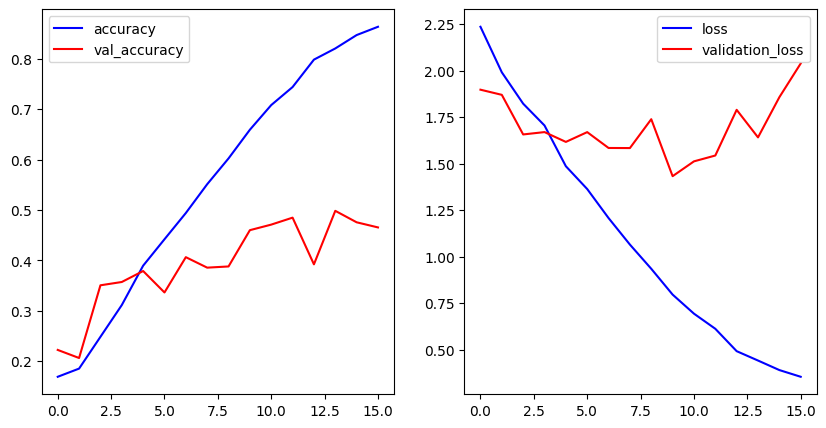

In [11]:
#plotting acc and loss curves to get a beeter understanding of our network's performance
plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],     color='b', label="accuracy")
plt.plot(history.history['val_accuracy'], color='r', label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],     color='b', label="loss")
plt.plot(history.history['val_loss'], color='r', label="validation_loss")
plt.legend()


let's see how good our net is on each class separately


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(validation_generator)#, 7178 // 64+1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = validation_generator.classes

print('Confusion Matrix')
confusion_matrix(true_classes, y_pred)

113/113 [==============================] - 10s 92ms/step
Confusion Matrix


array([[ 294,   10,   95,  162,  298,   75,   24],
       [  18,   48,   10,   13,   14,    8,    0],
       [ 126,   11,  245,  152,  312,   90,   88],
       [  89,    2,   56, 1237,  303,   53,   34],
       [  85,    6,   78,  157,  808,   72,   27],
       [ 161,   10,  143,  217,  461,  224,   31],
       [  38,    2,   96,   78,  152,   17,  448]])

In [13]:
from sklearn.metrics import classification_report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.36      0.31      0.33       958
     disgust       0.54      0.43      0.48       111
        fear       0.34      0.24      0.28      1024
       happy       0.61      0.70      0.65      1774
     neutral       0.34      0.66      0.45      1233
         sad       0.42      0.18      0.25      1247
    surprise       0.69      0.54      0.60       831

    accuracy                           0.46      7178
   macro avg       0.47      0.44      0.44      7178
weighted avg       0.47      0.46      0.44      7178



seems good :)